In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from dataclasses import dataclass
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

from diffuse.models import MLP
from diffuse.noise_scheduler import NoiseScheduler
%load_ext autoreload
%autoreload 2

@dataclass
class Config:
    experiment_name: str = 'base'
    dataset: str = 'dino'
    train_batch_size: int = 128
    eval_batch_size: int = 1000
    num_epochs: int = 20
    learning_rate: float = 1e-3
    num_timesteps: int = 50
    beta_schedule: str = "log2"
    embedding_size: int = 128
    hidden_size: int = 128
    hidden_layers: int = 3
    time_embedding: str = "sinusoidal"
    input_embedding: str = "sinusoidal"
    save_images_step: int = 1

c = Config()

ImportError: cannot import name 'MLP' from 'diffuse.models' (unknown location)

## Training

In [ ]:
device = torch.device('cpu')
dataset = datasets.get_dataset('moons')

dataloader = DataLoader(
    dataset, batch_size=c.train_batch_size, shuffle=True, drop_last=True)

model = MLP(
    hidden_size=c.hidden_size,
    hidden_layers=c.hidden_layers,
    emb_size=c.embedding_size,
    time_emb=c.time_embedding,
    input_emb=c.input_embedding).to(device)

noise_scheduler = NoiseScheduler(
    num_timesteps=c.num_timesteps,
    beta_schedule=c.beta_schedule)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=c.learning_rate,
)

global_step = 0
losses = []
epoch_to_samples = dict()

print("Training model...")

for epoch in range(c.num_epochs):
    model.train()
    for step, batch in enumerate(dataloader):
        batch = batch[0]
        noise = torch.randn(batch.shape)
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = model(noisy.to(device), timesteps.to(device))
        loss = F.mse_loss(noise_pred, noise.to(device))
        optimizer.zero_grad()
        loss.backward(loss)

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        losses.append(float(loss.detach().item()))

        # progress_bar.set_postfix(**logs)
        if global_step % 300 == 0:
            loss = sum(losses[-30:])/min(30,len(losses)) # running loss
            print(f'e{epoch}|s{global_step} loss={loss:.2f}')

        global_step += 1

    if epoch % c.save_images_step == 0 or epoch == c.num_epochs - 1:
        epoch_to_samples[epoch]=model.sample(noise_scheduler)

Training model...
e0|s0 loss=0.97
e4|s300 loss=0.74
e9|s600 loss=0.69
e14|s900 loss=0.73
e19|s1200 loss=0.73


## Sampling

(-6.0, 6.0)

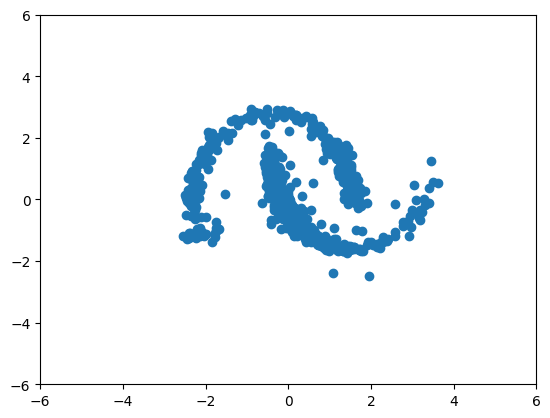

In [ ]:
fig,ax = plt.subplots()
s = epoch_to_samples[16][40]
ax.scatter(s[:,0],s[:,1])
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)

(-6.0, 6.0)

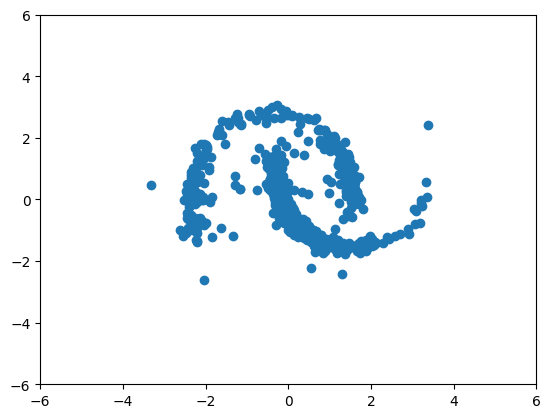

In [ ]:
fig,ax = plt.subplots()
s = epoch_to_samples[16][40]
ax.scatter(s[:,0],s[:,1])
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)

In [2]:
print("Saving model...")
outdir = f"exps/{config.experiment_name}"
os.makedirs(outdir, exist_ok=True)
torch.save(model.state_dict(), f"{outdir}/model.pth")

print("Saving images...")
imgdir = f"{outdir}/images"
os.makedirs(imgdir, exist_ok=True)
frames = np.stack(frames)
xmin, xmax = -6, 6
ymin, ymax = -6, 6
for i, frame in enumerate(frames):
    plt.figure(figsize=(10, 10))
    plt.scatter(frame[:, 0], frame[:, 1])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.savefig(f"{imgdir}/{i:04}.png")
    plt.close()

print("Saving loss as numpy array...")
np.save(f"{outdir}/loss.npy", np.array(losses))

print("Saving frames...")
np.save(f"{outdir}/frames.npy", frames)

Saving model...


NameError: name 'config' is not defined

In [110]:
x = dataset.tensors[0]

emb.shape

In [120]:
emb.shape

torch.Size([50])

In [128]:
(emb.unsqueeze(0) * x.unsqueeze(-1)).shape

torch.Size([8000, 2, 50])

In [135]:
x.unsqueeze(-1).shape, emb.unsqueeze(0).shape

(torch.Size([8000, 2, 1]), torch.Size([1, 50]))

In [138]:
size=100
half_size = size // 2
emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
emb = torch.exp(-emb * torch.arange(half_size))
# (B,2,1) * (1,50)
emb = x.unsqueeze(-1) * emb.unsqueeze(0)
emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
# plt.plot(emb)

In [142]:
emb.shape

torch.Size([8000, 2, 100])

In [140]:
emb.shape

torch.Size([8000, 2, 100])

tensor([0.1880])